In [1]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import convolve1d
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore, get_types_from_msg


In [2]:
REPO_PATH = '/home/stewart/Downloads/soft_stewart'
PKG_PATH = REPO_PATH + '/stewart_ros/src/koopman_mpc'
SERVO_ANGLES_MSG_PATH = REPO_PATH + '/stewart_ros/src/platform_interfaces/msg/ServoAngles.msg'
BALL_ODOMETRY_MSG_PATH = REPO_PATH + '/stewart_ros/src/platform_interfaces/msg/BallOdometry.msg'
MOTOR_ODOM_MSG_PATH = REPO_PATH + '/stewart_ros/src/platform_interfaces/msg/Odom.msg'

# Get message format
servo_angles_msg_text = Path(SERVO_ANGLES_MSG_PATH).read_text()
ball_odometry_msg_text = Path(BALL_ODOMETRY_MSG_PATH).read_text()
motor_odom_msg_text = Path(MOTOR_ODOM_MSG_PATH).read_text()

# Add the ServoAngle message format to the type store
type_store = get_typestore(Stores.LATEST)
add_types = {}
add_types.update(get_types_from_msg(servo_angles_msg_text, 'platform_interfaces/msg/ServoAngles'))
add_types.update(get_types_from_msg(ball_odometry_msg_text, 'platform_interfaces/msg/BallOdometry'))
add_types.update(get_types_from_msg(motor_odom_msg_text, 'platform_interfaces/msg/Odom'))
type_store.register(add_types)

# Dictionary to store results
results = {
    'p_d': [],
    'error_avg': [],
    'error_std': []
}

rosbag_list = ["/home/stewart/Documents/Dev/koopman_ws/src/active-koopman-cpp/bags/rosbag2_2024_11_14-17_44_38"]

p_data_raw = []
p_d_data_raw = []
v_data_raw = []
u_data_raw = []

p_time_raw = []
p_d_time_raw = []
v_time_raw = []
u_time_raw = []

for rosbag in rosbag_list:
    with Reader(rosbag) as reader:
        for connection, timestamp, raw_data in reader.messages():
            # Get timestamp (second)
            time_curr = timestamp / 1e9

            # Get filtered ball pose data
            if connection.topic == '/filtered_ball_pose':
                msg = type_store.deserialize_cdr(raw_data, connection.msgtype)
                p_time_raw.append(time_curr)
                p_data_raw.append(np.array([msg.x, msg.y]))

            # Get filtered ball velocity data
            if connection.topic == '/filtered_ball_pose':
                msg = type_store.deserialize_cdr(raw_data, connection.msgtype)
                v_time_raw.append(time_curr)
                v_data_raw.append(np.array([msg.xdot, msg.ydot]))

            # Get desired ball position data
            if connection.topic == '/desired_ball_state':
                msg = type_store.deserialize_cdr(raw_data, connection.msgtype)
                p_d_time_raw.append(time_curr)
                p_d_data_raw.append(np.array([msg.x, msg.y]))

            # Get raw control data and timestamps
            if connection.topic == '/servo_angles':
                msg = type_store.deserialize_cdr(raw_data, connection.msgtype)
                u_time_raw.append(time_curr)
                u_data_raw.append(np.array([msg.angle_1, msg.angle_2, msg.angle_3, msg.angle_4, msg.angle_5, msg.angle_6]))

    print("Data loaded!")

# Plot the average distance for each desired ball position
p_array = np.array(p_data_raw)
p_x = p_array[:, 0]  # x-coordinates
p_y = p_array[:, 1]  # y-coordinates


Data loaded!


In [3]:
len(p_x)

13578

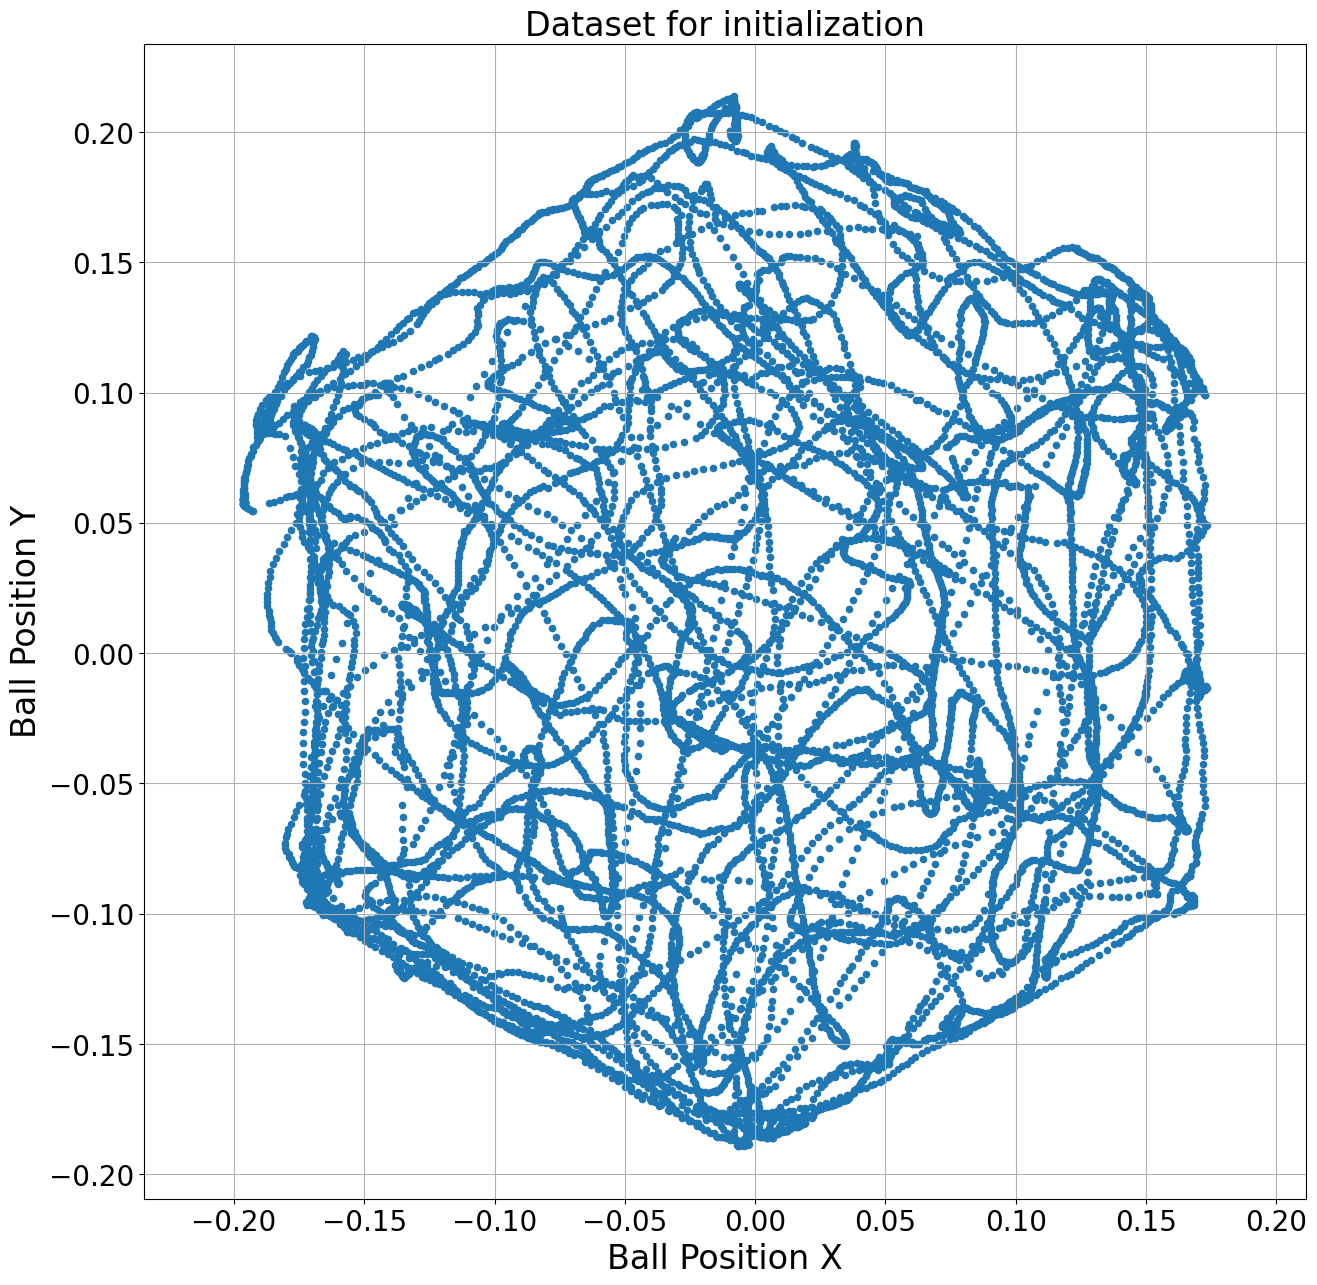

In [4]:
plt.figure(figsize=(15, 15))
plt.scatter(p_x, p_y, label='Ball Position', s=20)
plt.xlabel('Ball Position X', fontsize=24)
plt.ylabel('Ball Position Y', fontsize=24)
plt.title('Dataset for initialization', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.axis('equal')
plt.show()
